In [1]:
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from get_station_data import ghcnd

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

crs = ccrs.PlateCarree()
%matplotlib inline 

The "station".csv files contain all daily elements for that GHCN station for its entire period of record. 
Each element-day is provided on a separate line and all files are updated daily for the entire period of record.

The following information serves as a definition of each field for all element-day records. 
Each field described below is separated by a comma ( , ) and follows the order below:

ID = 11 character station identification code
YEAR/MONTH/DAY = 8 character date in YYYYMMDD format (e.g. 19860529 = May 29, 1986)
ELEMENT = 4 character indicator of element type 
DATA VALUE = 5 character data value for ELEMENT 
M-FLAG = 1 character Measurement Flag 
Q-FLAG = 1 character Quality Flag 
S-FLAG = 1 character Source Flag 
OBS-TIME = 4-character time of observation in hour-minute format (i.e. 0700 =7:00 am); if no ob time information 
is available, the field is left empty

See section III of the GHCN-Daily readme.txt file (ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
for an explanation of ELEMENT codes and their units as well as the M-FLAG, Q-FLAG and S-FLAG.

The OBS-TIME field is populated with the observation times contained in NOAA/NCEI's HOMR station history database.  


In [120]:
stn_md = ghcnd.get_stn_metadata()
stn_md.lat = stn_md.lat 
stn_md

,station,lat,lon,elev,name,start_year,end_year
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,1949.0,1949.0
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,1961.0,1961.0
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,1944.0,2023.0
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,1983.0,2023.0
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,1983.0,2023.0
...,...,...,...,...,...,...,...
124949,ZI000067969,-21.0500,29.3670,861.0,WEST NICHOLSON,1962.0,1990.0
124950,ZI000067975,-20.0670,30.8670,1095.0,MASVINGO,1951.0,2023.0
124951,ZI000067977,-21.0170,31.5830,430.0,BUFFALO RANGE,1968.0,1990.0
124952,ZI000067983,-20.2000,32.6160,1132.0,CHIPINGE,1951.0,2020.0


In [121]:
stn_md_usa

,station,lat,lon,elev,name,start_year,end_year


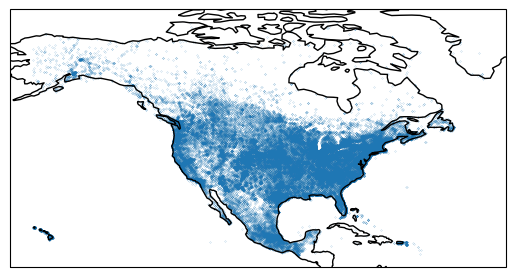

In [146]:
def get_usa_stations(stn_md):
    """
    Uses approx latitude and longitude values to get stations in mainland USA.
    """
    min_lat = 15.0
    max_lat = 75.0
    min_lon = -160.0
    max_lon = -45
    return stn_md[(min_lat <= stn_md.lat) & (stn_md.lat <= max_lat)
                  &(min_lon <= stn_md.lon) & (stn_md.lon <= max_lon)]

stn_md_usa = get_usa_stations(stn_md)


# Split the DataFrame into two subsets

fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
ax.scatter(stn_md_usa.lon, stn_md_usa.lat, s=0.01)
ax.coastlines()


We are no going to select a subset of these stations to model, since there are a few too many to work with here for a demo, let's try look at 10000. 

For now we are just going to look at the variable TMAX, which is the maximum temperature recorded over the day, and only in 2013-2014

In [131]:
stn_md_usa_shuffled = stn_md_usa.sample(frac=1, random_state=43)  # Use random_state for reproducibility
# n_train_stations = 30
n_stations = 2000
all_stations_md = stn_md_usa_shuffled[:n_stations]

date_range = ( "2013-01-01",  "2014-12-31")
all_raw_station_data= ghcnd.get_data(all_stations_md, include_flags=False, element_types=["TMAX"], date_range=date_range)

# change to degrees to K
all_raw_station_data["value"] += 273.15
all_raw_station_data

100%|██████████| 2000/2000 [01:42<00:00, 19.53it/s]
/Users/magnus/Documents/phd/code/repos/get-station-data/get_station_data/ghcnd.py:164: UserWarning: 1743 stations had no data, caused by not recording the requested element type or date range.
  warnings.warn(f"{empty_dfs} stations had no data, caused by not recording the requested element type or date range.")


,station,element,value,date,lon,lat,elev,name
341650,USC00404561,TMAX,280.35,2013-01-01,-88.8456,35.6214,121.9,TN JACKSON EXP STN
341662,USC00404561,TMAX,278.15,2013-01-02,-88.8456,35.6214,121.9,TN JACKSON EXP STN
341674,USC00404561,TMAX,275.35,2013-01-03,-88.8456,35.6214,121.9,TN JACKSON EXP STN
341686,USC00404561,TMAX,279.85,2013-01-04,-88.8456,35.6214,121.9,TN JACKSON EXP STN
341698,USC00404561,TMAX,282.05,2013-01-05,-88.8456,35.6214,121.9,TN JACKSON EXP STN
...,...,...,...,...,...,...,...,...
210831,USC00420738,TMAX,278.15,2014-12-27,-109.4847,37.6133,1839.5,UT BLANDING
210837,USC00420738,TMAX,271.45,2014-12-28,-109.4847,37.6133,1839.5,UT BLANDING
210843,USC00420738,TMAX,273.15,2014-12-29,-109.4847,37.6133,1839.5,UT BLANDING
210849,USC00420738,TMAX,274.25,2014-12-30,-109.4847,37.6133,1839.5,UT BLANDING


Unfortunateley not all the stations have data for all times, we can look at the number of unique staion IDs to see how many we have.

Only ~1000 have data, let's use some of these for training and the rest for validation.

In [132]:
len(pd.unique(all_raw_station_data.name))

all_stations_md = all_stations_md[all_stations_md.name.isin(all_raw_station_data.name)]

We can visualise this with the all the stations to see how our sample compares.

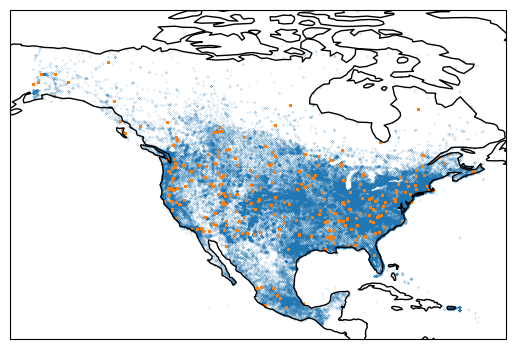

In [133]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
ax.scatter(stn_md_usa.lon, stn_md_usa.lat, s=0.01)
ax.scatter(all_raw_station_data.lon, all_raw_station_data.lat, s=1)
ax.coastlines()

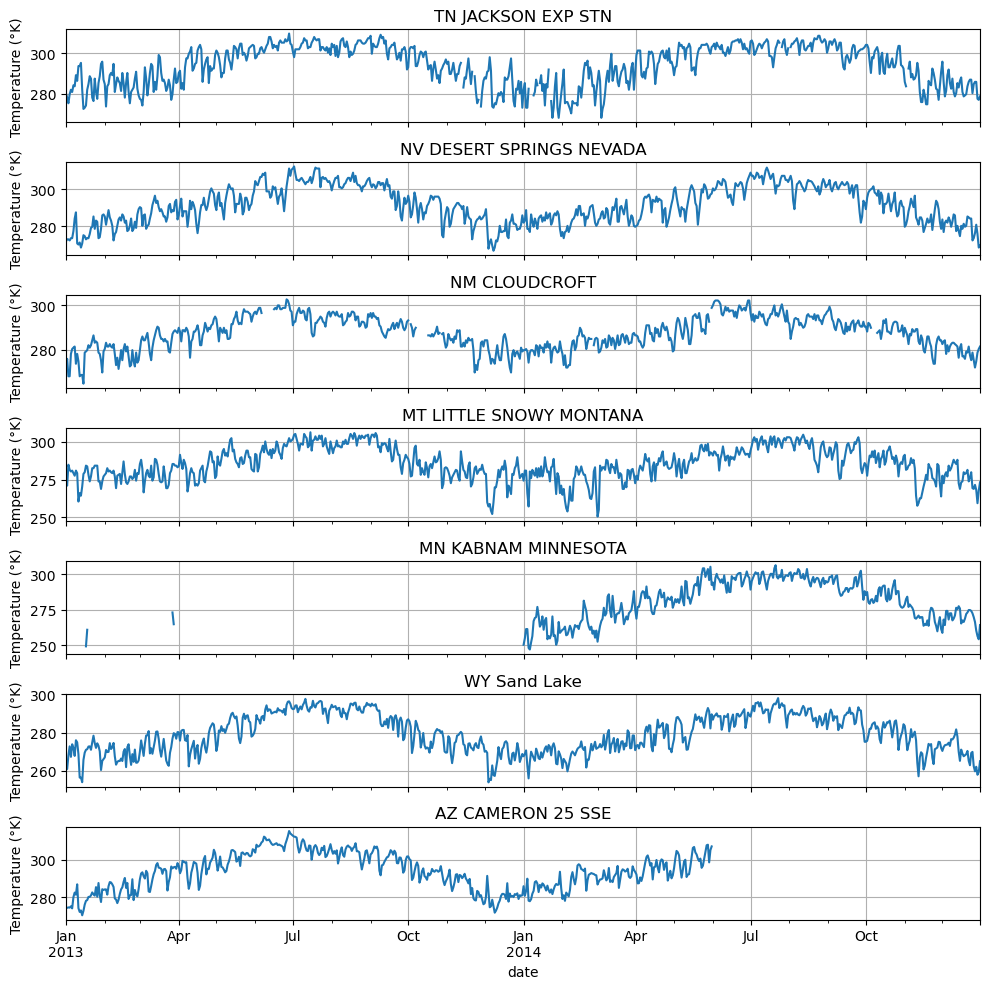

In [134]:
station_pivot_df = all_raw_station_data.pivot(index='date', columns='name', values='value')

stations = all_stations_md.name

fig, axes = plt.subplots(7, 1, figsize=(10, 10 ), sharex=True)

for i, (station, ax) in enumerate(zip(stations, axes)):
    station_pivot_df[station].plot(ax=ax)
    ax.set_title(station)
    ax.set_ylabel('Temperature (°K)')
    ax.grid(True)
plt.tight_layout()


As we can see, there is quite a lot of missing data. Fortunately this shouldn't be a problem for us. 

Now let's take a look at the gridded data, which we can acesss using the xarray tutorial.

In [135]:
ds_raw = xr.tutorial.open_dataset("air_temperature")
ds_raw

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [136]:
ds_gridded = ds_raw.resample(time="D").max()


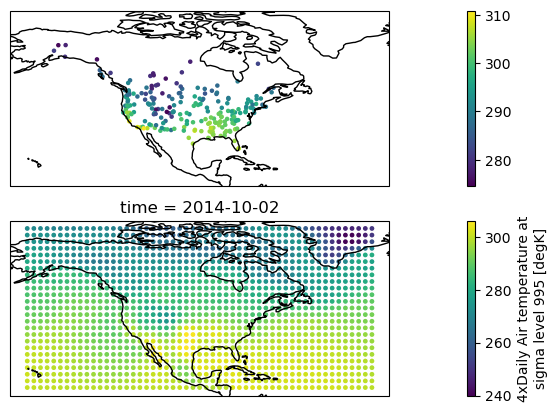

In [142]:
date = pd.to_datetime("2014-10-02")


fig, ax = plt.subplots(2, 1, subplot_kw=dict(projection=crs), figsize=(20, 5), sharex=True, sharey=True)
# # xr.plot.scatter(station_xr.isel(date=-1) + 273, y="lat", x="lon", hue="value")
im1 = ax[0].scatter(all_raw_station_data.lon[all_raw_station_data.date == date],
                    all_raw_station_data.lat[all_raw_station_data.date == date], s=5, c=all_raw_station_data.value[all_raw_station_data.date == date])
ax[0].coastlines()
plt.colorbar(im1, ax=ax[0])

xr.plot.scatter(ds_raw.sel(time=date), y="lat", x="lon", hue="air", ax=ax[1], s=20)
ax[1].coastlines()

In [54]:
# fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs), figsize=(20, 5))


IndexError: index 3 is out of bounds for axis 0 with size 3